In [1]:
import os

In [2]:
os.chdir('/Users/layne/Desktop/chest_xray/train/normal')
healthy = os.listdir('.')
healthy = [os.path.abspath(f) for f in healthy]

In [3]:
os.chdir('/Users/layne/Desktop/chest_xray/train/pneumonia')
pneumonia = os.listdir('.')
pneumonia = [os.path.abspath(f) for f in pneumonia]

In [4]:
import random
random.shuffle(healthy)
random.shuffle(pneumonia)

In [5]:
healthy_subset = healthy[:125]
pneumonia_subset = pneumonia[:125]

In [6]:
len(healthy_subset)

125

In [7]:
len(pneumonia_subset)

125

In [8]:
target_dir = '/Users/layne/Desktop/xray_mixed_patients'

Rename when moving over "healthy-i.jpg"

In [9]:
import shutil

In [10]:
for i, file_path in enumerate(healthy_subset):
    target_file_path = f"/Users/layne/Desktop/xray_mixed_patients/healthy-{i}.jpeg"
    shutil.copyfile(file_path, target_file_path)

In [11]:
for i, file_path in enumerate(pneumonia_subset):
    target_file_path = f"/Users/layne/Desktop/xray_mixed_patients/pneumonia-{i}.jpeg"
    shutil.copyfile(file_path, target_file_path)

In [12]:
os.chdir('/Users/layne/Desktop/xray_mixed_patients')

In [13]:
mixed = os.listdir('.')

In [14]:
mixed.remove('.DS_Store')

In [15]:
len(mixed)

250

In [16]:
from PIL import Image

In [17]:
for file_path in mixed:
    img = Image.open(file_path)
    img = img.resize((90,120))
    img = img.convert(mode='L')
    img.save(file_path)

In [18]:
import numpy as np

In [19]:
mixed_arr = []
for file in mixed:
    if 'healthy' in file:
        arr = np.array([0,file])
    elif 'pneumonia' in file:
        arr = np.array([1,file])
    mixed_arr.append(arr)

In [20]:
mixed_np = np.array(mixed_arr)

In [21]:
import pandas as pd

/Users/layne/.pyenv/versions/3.7.6/envs/jupyterlab/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [22]:
df = pd.DataFrame(mixed_np, columns=['status', 'path'])

---

In [23]:
import os
os.chdir('/Users/layne/Desktop/aiqc')

In [24]:
import aiqc
from aiqc import examples

In [25]:
from importlib import reload; aiqc.delete_db(True); reload(aiqc); aiqc.create_db()


=> Success - deleted database file at path:
/Users/layne/Library/Application Support/aiqc/aiqc.sqlite3


=> Success - created database file for machine learning metrics at path:
/Users/layne/Library/Application Support/aiqc/aiqc.sqlite3


=> Success - created the following tables within database:
['algorithm', 'batch', 'datapipeline', 'dataset', 'experiment', 'featureset', 'file', 'fold', 'foldset', 'hyperparamcombo', 'hyperparamset', 'image', 'job', 'label', 'preprocess', 'result', 'splitset', 'tabular']



---

In [26]:
dataset_tab = aiqc.Dataset.Tabular.from_pandas(dataframe=df, name='xray', dtype={'status':'int','path':'string'})

In [27]:
dir_path = '/Users/layne/Desktop/xray_mixed_patients'

In [28]:
dataset_images = aiqc.Dataset.Image.from_folder(dir_path)

In [29]:
#dataset_images.to_numpy()

In [30]:
label = dataset_tab.make_label(columns=['status'])

In [31]:
#label.to_numpy()

In [32]:
featureset = dataset_images.make_featureset()

In [33]:
#featureset.to_numpy()

In [34]:
splitset = featureset.make_splitset(label_id=label.id, size_test=0.30)

Should refactor splitset so that it doesn't read all image features into memory.

In [90]:
import keras
from keras import metrics
from keras.models import Sequential
from keras.callbacks import History
from keras.layers import Conv2D, Dense, Dropout
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten

In [91]:
def function_model_build(**hyperparameters):
    model = Sequential()
    model.add(Conv2D(32, (6, 6), input_shape=(180, 180, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, (5, 5), input_shape=(180, 180, 3), padding='same', activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', ))

    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform'))
        
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [92]:
def function_model_train(model, samples_train, samples_evaluate, **hyperparameters):
    model.fit(
            samples_train["features"]
            , samples_train["labels"]
            , validation_data = (
                    samples_evaluate["features"]
                    , samples_evaluate["labels"]
            )
            , verbose = 0
            , batch_size = 3
            , epochs = hyperparameters['epoch_count']
            , callbacks=[History()]
    )

    return model

In [93]:
def function_model_predict(model, samples_predict):
    probabilities = model.predict(samples_predict['features'])
    # This is the official keras replacement for binary classes `.predict_classes()`
    # It returns one array per sample: `[[0][1][0][1]]`
    predictions = (probabilities > 0.5).astype("int32")

    return predictions, probabilities

In [94]:
def function_model_loss(model, samples_evaluate):
    metrics = model.evaluate(samples_evaluate['features'], samples_evaluate['labels'], verbose=0)
    if (isinstance(metrics, list)):
        loss = metrics[0]
    elif (isinstance(metrics, float)):
        loss = metrics
    else:
        raise ValueError(f"\nYikes - The 'metrics' returned are neither a list nor a float:\n{metrics}\n")
    return loss

In [95]:
algorithm = aiqc.Algorithm.create(
    library = "keras"
    , analysis_type = "classification_binary"
    , function_model_build = function_model_build
    , function_model_train = function_model_train
    , function_model_predict = function_model_predict
    , function_model_loss = function_model_loss
)

OperationalError: disk I/O error

In [85]:
hyperparameters = {
    "epoch_count": [10]
}

hyperparamset = aiqc.Hyperparamset.from_algorithm(
    algorithm_id = algorithm.id
    , description = "experimenting with neuron count, layers, and epoch count"
    , hyperparameters = hyperparameters
)

In [86]:
batch = aiqc.Batch.from_algorithm(
    algorithm_id = algorithm.id
    , splitset_id = splitset.id
    , hyperparamset_id = hyperparamset.id
    , foldset_id = None
    , preprocess_id = None
)

In [87]:
batch.run_jobs()

🔮 Training Models 🔮: 100%|█████████████████████████████████████████| 1/1 [02:12<00:00, 132.75s/it]


In [88]:
batch.get_statuses()

{9: 'Queued'}

In [89]:
batch.metrics_to_pandas()


~:: Patience, young Padawan ::~

The Jobs have not completed yet, so there are no Results to be had.



""


In [78]:
aiqc.Job.get_by_id(6).hyperparamcombo.hyperparameters

{'epoch_count': 30}

In [5]:
import aiqc

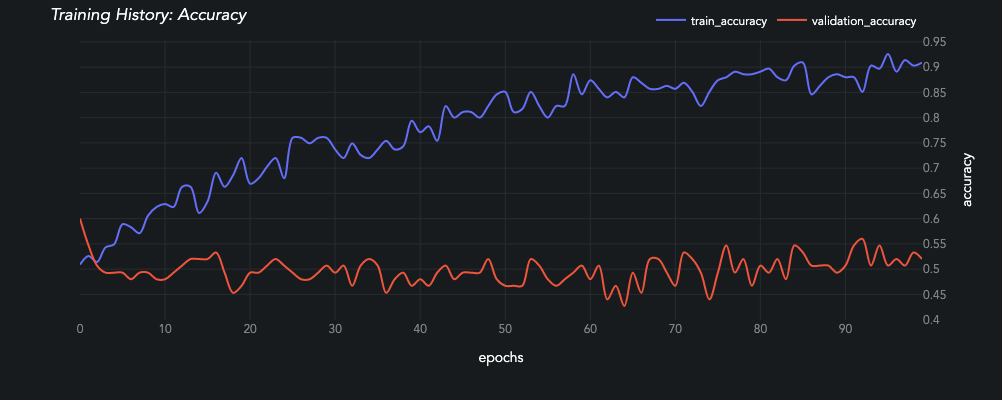

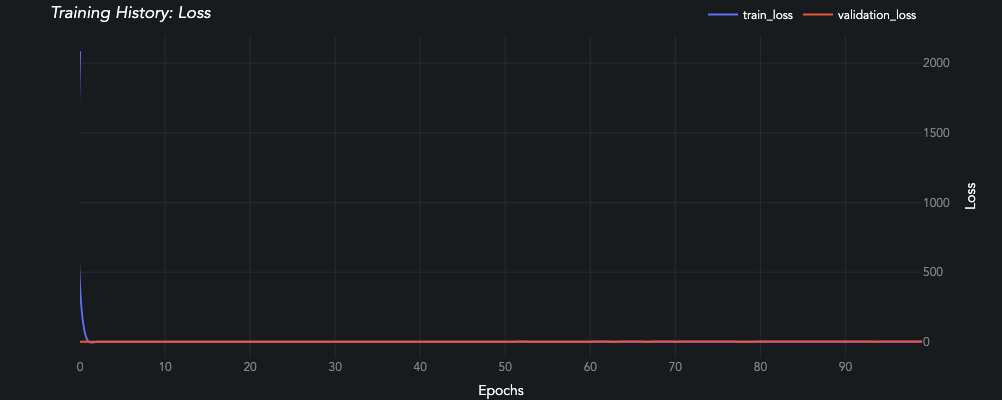

In [84]:
aiqc.Job.get_by_id(8).results[0].plot_learning_curve()

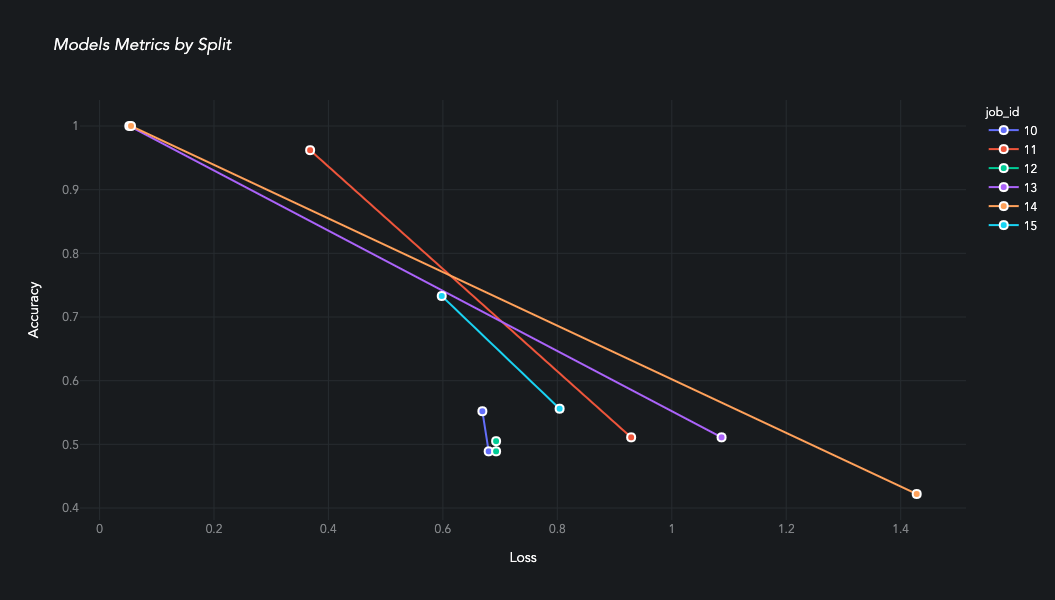

In [94]:
batch.plot_performance()

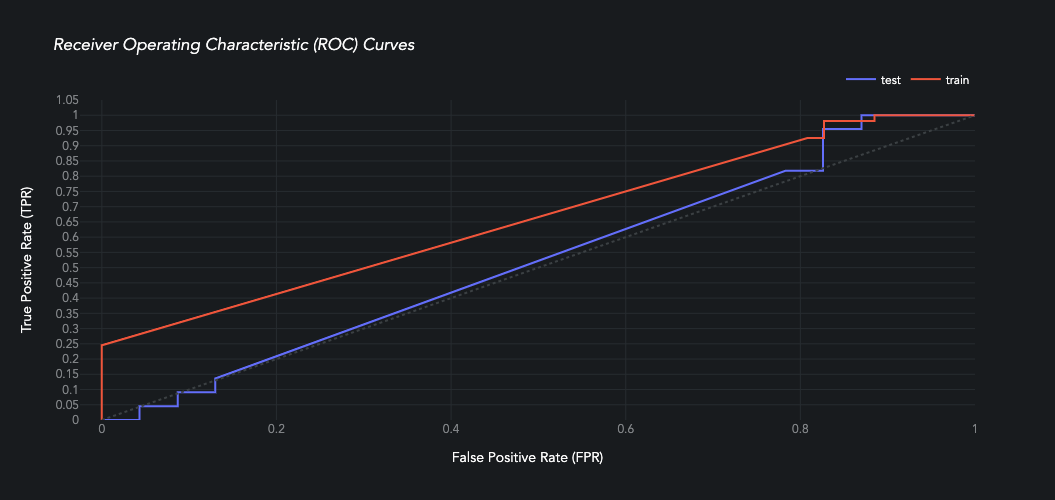

In [96]:
batch.jobs[0].results[0].plot_roc_curve()

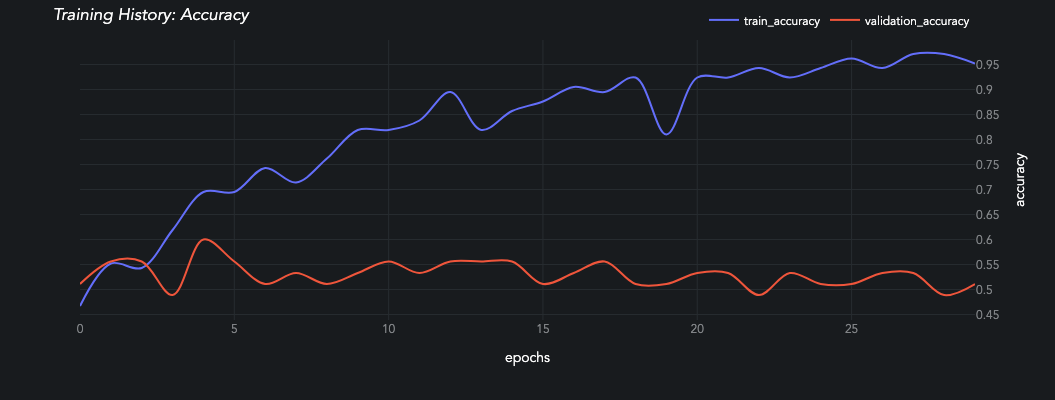

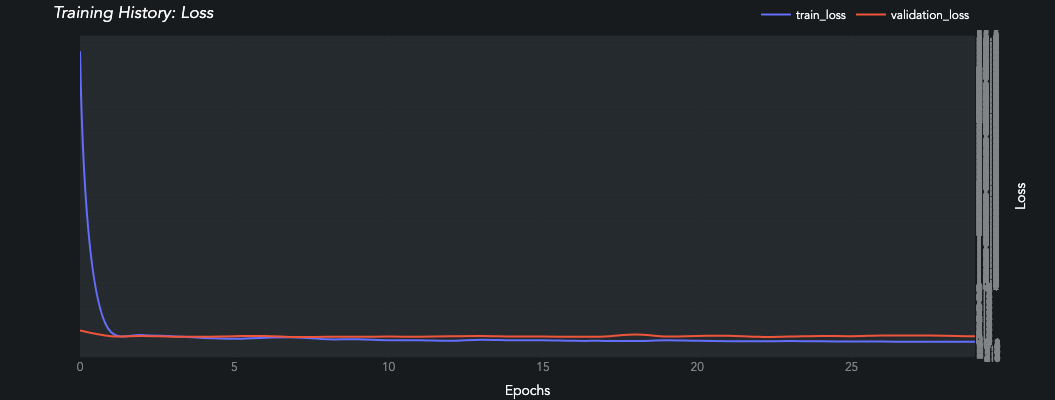

In [100]:
batch.jobs[3].results[0].plot_learning_curve()

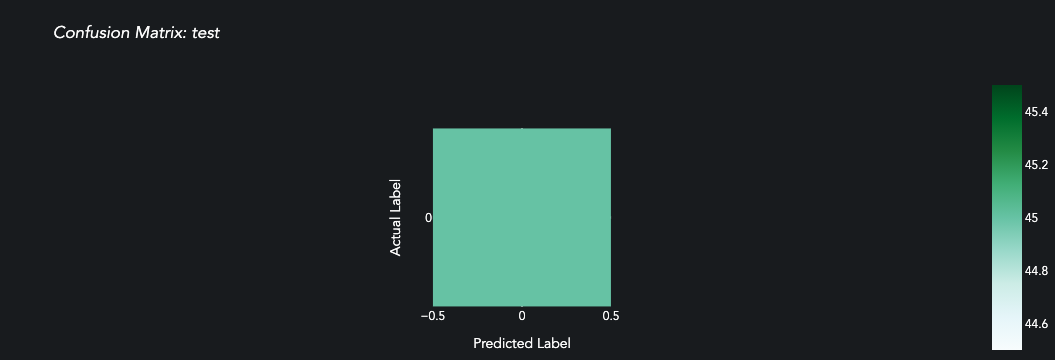

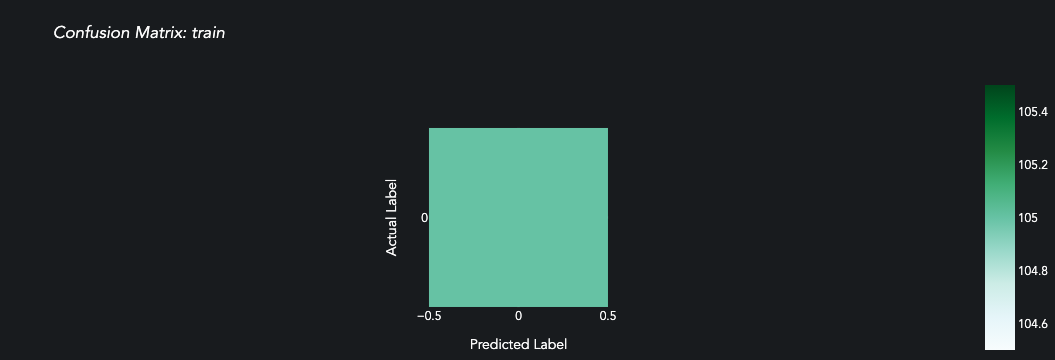

In [200]:
batch.jobs[4].results[0].plot_confusion_matrix()